In [1]:
import sys
import os
from glob import glob

import scanpy as sc

import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import f1_score as f1
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import confusion_matrix
from scipy.stats import mannwhitneyu

import PyComplexHeatmap as ch

import matplotlib.pylab as plt

from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, recall_score, precision_score

from pyprojroot import here

import warnings
warnings.filterwarnings("ignore")

sys.path.insert(1, str(here('bin')))

from customPythonFunctions import getClassMetricsDF

from customPalette import annotation_Level1_palette, annotation_Level1_LowQFilt_sortednames

from PyComplexHeatmap import *
import warnings

from customPalette import diseases_palette, diseaseCategories, diseasesGroup_palette

In [2]:
diseaseCategories['Na'] = 'Na'
diseasesGroup_palette['Na'] = '#ffffff'

In [3]:
cell_type_order = [c for c in annotation_Level1_LowQFilt_sortednames if c not in ['Cycling_cells','Progenitors','Platelets','RBC']]

In [4]:
optimization_metric = 'F1'

### Computing additional metrics

In [5]:
def get_add_metric(disease_true, disease_pred):
    from sklearn.metrics import confusion_matrix
    
    disease_true = np.array(disease_true)
    disease_pred = np.array(disease_pred)
    res = []
    for d in np.unique(disease_true):
        support = (disease_true==d).sum()
        
        tn, fp, fn, tp = confusion_matrix(disease_true==d, disease_pred==d).ravel()
    
    
        prec = (tp / (tp+fp))
        recall = (tp / (tp+fn))
        specificity = (tn / (tn+fp))
        
        res.append([d, prec, recall, specificity, support])
    
    res = pd.DataFrame(res).fillna(0).set_index(0)
    Wprecision = np.average(res.loc[:,1], weights= res.loc[:,4])
    Wrecall = np.average(res.loc[:,2], weights= res.loc[:,4])
    Wspecifitity = np.average(res.loc[:,3], weights= res.loc[:,4])
    return (Wprecision,Wrecall,Wspecifitity)

### Defining integration parameters

In [6]:
integration_method = 'scANVI'
query_dataset = 'EXTERNAL'
embedded_space = 'cell'
n_Patient_embedded = 0
batch_key = 'Pool'
annotation = 'Level1'
bestClf_family = 'LinearSVC'

n_embedded = 30

In [7]:
M_dir= f"SCGT00_{query_dataset}_{integration_method}_{n_embedded}_{n_Patient_embedded}"
os.makedirs(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}"), exist_ok=True)

In [8]:
with open(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/info.txt"), 'a') as f:
    f.writelines(f"integration_method = {integration_method}\n")
    f.writelines(f"query_dataset = {query_dataset}\n")
    f.writelines(f"embedded_space = {embedded_space}\n")
    f.writelines(f"n_embedded = {n_embedded}\n")
    f.writelines(f"n_Patient_embedded = {n_Patient_embedded}\n")
    f.writelines(f"batch_key = {batch_key}\n")
    f.writelines(f"annotation = {annotation}\n")
    f.writelines(f"bestClf_family = {bestClf_family}\n")

### Loading original dataset

to retrieve pool info

In [8]:
EXTdata = sc.read_h5ad(here('01_data_processing/SCGT00_CentralizedDataset/results/SCGT00_EXTERNAL_afterQC.h5ad'))

In [9]:
MAINdata = sc.read_h5ad(here('01_data_processing/SCGT00_CentralizedDataset/results/SCGT00_MAIN_afterQC.h5ad'))

In [10]:
MAINpatient = MAINdata.obs[['sampleID','batches','disease','sex','binned_age']].drop_duplicates().reset_index(drop=True)

### Loading results

#### Loading true and predicted labels

In [11]:
labels_df_dir= here(f'03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/results_batches/label_predicted_dataframes/')
pt_i = os.path.join(labels_df_dir,f"{integration_method}_{embedded_space}_{n_embedded}nEmb_{n_Patient_embedded}nPEmb_{batch_key}_{annotation}_optF1_{query_dataset}_{bestClf_family}.pkl")

In [38]:
labels_df = pd.read_pickle(pt_i)
labels_df.rename({'majority_pred':'Majority vote', 'disease':'disease_true'}, axis=1, inplace=True)
labels_df.columns = [c.replace('disease_pred_','') for c in labels_df.columns]
labels_df

,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,Majority vote,disease_true
sampleID,,,,,,,,,,,,,
SCGT00_I012013.3P_T0,CD,CD,CD,CD,CD,CD,CD,SLE,CD,SLE,UC,CD,CD
SCGT00_I012015.3P_T0,UC,CD,CD,UC,CD,CD,CD,CD,CD,CD,CD,CD,CD
SCGT00_I0121.3P_T0,CD,CD,CD,CD,CD,PSA,UC,CD,CD,CD,CD,CD,CD
SCGT00_I0122.3P_T0,UC,UC,UC,CD,SLE,UC,CD,CD,CD,SLE,SLE,nan,CD
SCGT00_I0124.3P_T0,UC,UC,CD,UC,CD,CD,UC,UC,CD,CD,CD,CD,CD
SCGT00_I0125.3P_T0,CD,UC,UC,CD,CD,PSA,CD,CD,CD,CD,RA,CD,CD
SCGT00_I0126.3P_T0,CD,CD,UC,CD,UC,RA,CD,PS,CD,CD,CD,CD,CD
SCGT00_I0128.3P_T0,CD,CD,CD,CD,UC,CD,CD,CD,CD,UC,CD,CD,CD
SCGT00_I014011.3P_T0,SLE,CD,SLE,RA,RA,SLE,SLE,SLE,SLE,SLE,CD,SLE,SLE


In [13]:
result_classficiation = EXTdata.obs[['sampleID','batches','sex','binned_age']].drop_duplicates().merge(labels_df.reset_index(), on='sampleID')

In [40]:
result_classficiation.head()

,sampleID,batches,sex,binned_age,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,Majority vote,disease_true,correct
0,SCGT00_I5015.3P_T0,RA_Pool5Pool7,female,51-60,PSA,PSA,PSA,PS,CD,PSA,PSA,PSA,PSA,PSA,RA,PSA,RA,False
1,SCGT00_I5017.3P_T0,RA_Pool5Pool7,female,18-30,PSA,PSA,PSA,RA,SLE,RA,PSA,PSA,PSA,PSA,RA,PSA,RA,False
2,SCGT00_I5013.3P_T0,RA_Pool5Pool7,female,41-50,PSA,SLE,PSA,PS,RA,PSA,PSA,PSA,PSA,PSA,PSA,PSA,RA,False
3,SCGT00_I5020.3P_T0,RA_Pool5Pool7,female,51-60,PSA,RA,PSA,PS,SLE,PSA,PSA,PSA,PSA,PSA,RA,PSA,RA,False
4,SCGT00_I5019.3P_T0,RA_Pool5Pool7,female,61-70,PSA,PSA,PSA,PS,RA,PSA,PSA,PSA,PSA,PSA,PS,PSA,RA,False


In [15]:
result_classficiation = result_classficiation.assign(correct = lambda df: df['Majority vote'] == df['disease_true'])

In [16]:
correctedDF = result_classficiation.query("correct").value_counts('batches').reset_index().assign(correct=True)

In [17]:
uncorrectedDF = result_classficiation.query("correct==False").value_counts('batches').reset_index().assign(correct=False)

In [18]:
res = pd.concat([correctedDF,uncorrectedDF])

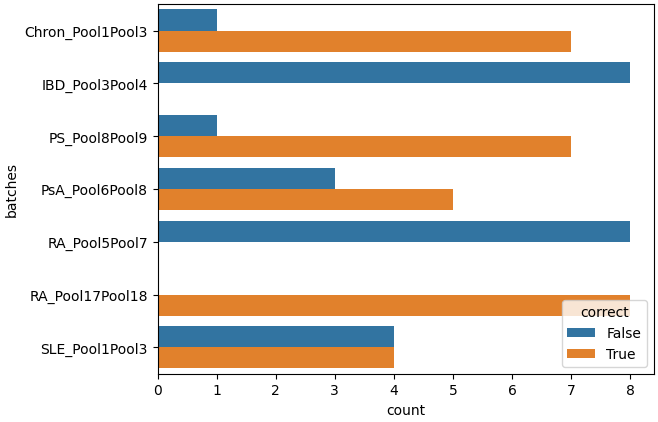

In [19]:
sns.barplot(y = 'batches', x = 'count', hue = 'correct', data=res)
plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/Pool_patient_results.pdf"))

In [20]:
result_classficiation.groupby(['batches','disease_true'], observed=True).size()

batches           disease_true
Chron_Pool1Pool3  CD              8
IBD_Pool3Pool4    CD              2
                  UC              6
PS_Pool8Pool9     PS              8
PsA_Pool6Pool8    PSA             8
RA_Pool5Pool7     RA              8
RA_Pool17Pool18   RA              8
SLE_Pool1Pool3    SLE             8
dtype: int64

In [21]:
result_classficiation.query("batches in ['RA_Pool5Pool7']")

,sampleID,batches,sex,binned_age,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,Majority vote,disease_true,correct
0,SCGT00_I5015.3P_T0,RA_Pool5Pool7,female,51-60,PSA,PSA,PSA,PS,CD,PSA,PSA,PSA,PSA,PSA,RA,PSA,RA,False
1,SCGT00_I5017.3P_T0,RA_Pool5Pool7,female,18-30,PSA,PSA,PSA,RA,SLE,RA,PSA,PSA,PSA,PSA,RA,PSA,RA,False
2,SCGT00_I5013.3P_T0,RA_Pool5Pool7,female,41-50,PSA,SLE,PSA,PS,RA,PSA,PSA,PSA,PSA,PSA,PSA,PSA,RA,False
3,SCGT00_I5020.3P_T0,RA_Pool5Pool7,female,51-60,PSA,RA,PSA,PS,SLE,PSA,PSA,PSA,PSA,PSA,RA,PSA,RA,False
4,SCGT00_I5019.3P_T0,RA_Pool5Pool7,female,61-70,PSA,PSA,PSA,PS,RA,PSA,PSA,PSA,PSA,PSA,PS,PSA,RA,False
5,SCGT00_I5016.3P_T0,RA_Pool5Pool7,female,51-60,PSA,PSA,PSA,PS,RA,RA,PSA,PSA,PSA,PSA,RA,PSA,RA,False
6,SCGT00_I5012.3P_T0,RA_Pool5Pool7,female,41-50,PSA,RA,PSA,PS,PSA,RA,PSA,SLE,PSA,PSA,PSA,PSA,RA,False
7,SCGT00_I5025.3P_T0,RA_Pool5Pool7,female,71-80,PSA,PSA,PSA,RA,PSA,PSA,PSA,PSA,RA,PSA,PSA,PSA,RA,False


In [22]:
result_classficiation.query("batches in ['IBD_Pool3Pool4']")

,sampleID,batches,sex,binned_age,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,Majority vote,disease_true,correct
32,SCGT00_I020011.3P_T0,IBD_Pool3Pool4,male,51-60,PSA,PSA,RA,PSA,PSA,RA,PSA,PSA,PSA,RA,RA,PSA,UC,False
33,SCGT00_I020013.3P_T0,IBD_Pool3Pool4,male,71-80,PSA,PSA,PS,SLE,RA,RA,PSA,RA,RA,PSA,RA,RA,CD,False
34,SCGT00_I020016.3P_T0,IBD_Pool3Pool4,male,18-30,RA,RA,PSA,RA,PSA,RA,PSA,RA,PS,RA,RA,RA,UC,False
35,SCGT00_I0206.3P_T0,IBD_Pool3Pool4,male,51-60,RA,PS,RA,RA,RA,RA,RA,PSA,RA,RA,NaN,RA,UC,False
36,SCGT00_I020014.3P_T0,IBD_Pool3Pool4,female,71-80,PS,RA,PS,PSA,SLE,RA,PSA,RA,PS,RA,RA,RA,UC,False
37,SCGT00_I020010.3P_T0,IBD_Pool3Pool4,female,41-50,RA,PSA,PS,PSA,RA,PS,PSA,PS,PSA,PS,PSA,PSA,CD,False
38,SCGT00_I020015.3P_T0,IBD_Pool3Pool4,female,41-50,RA,RA,PSA,RA,PSA,PS,PSA,RA,PS,SLE,RA,RA,UC,False
39,SCGT00_I020012.3P_T0,IBD_Pool3Pool4,male,51-60,RA,PSA,RA,PS,RA,PS,PS,PSA,PSA,RA,PSA,nan,UC,False


In [23]:
MAINpatient.query("disease == 'RA'").binned_age.value_counts()

binned_age
51-60    22
61-70    14
31-40    11
41-50    11
18-30     5
71-80     1
Name: count, dtype: int64

In [24]:
result_classficiation.to_csv(here('03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/SCGT00_EXTERNAL_classification_results.csv'))

**Considering all samples**

In [25]:
print(f"Majority Voting BAS: {balanced_accuracy_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}")
print(f"Majority Voting Weighetd F1: {f1_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true, average='weighted')}")
print(f"Majority Voting MCC: {matthews_corrcoef(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}")

# Additional metrics
Wprecision,Wrecall,Wspecifitity = get_add_metric(disease_pred=labels_df['Majority vote'], disease_true= labels_df.disease_true)

print(f"Majority Voting Weighet precision: {Wprecision}")
print(f"Majority Voting Weighet recall: {Wrecall}")
print(f"Majority Voting Weighet specificity: {Wspecifitity}")

Majority Voting BAS: 0.5333333333333333
Majority Voting Weighetd F1: 0.5567159586946907
Majority Voting MCC: 0.45882497271372874
Majority Voting Weighet precision: 0.5992063492063492
Majority Voting Weighet recall: 0.5535714285714286
Majority Voting Weighet specificity: 0.8889026915113872


In [27]:
with open(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/info.txt"), 'a') as f:
    f.writelines(f"Majority Voting BAS: {balanced_accuracy_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}\n")
    f.writelines(f"Majority Voting Weighetd F1: {f1_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true, average='weighted')}\n")


# Random assignment

In [26]:
import random
from tqdm import tqdm

#### Loading a set of datasets

It's needed only for retrieving sampleID metadata

In [27]:
TRAINdiseaseLabels = MAINpatient.groupby('sampleID',observed=True).agg({'disease':'first'}).disease.tolist()
len(TRAINdiseaseLabels)

152

In [28]:
EXTERNAL_true = result_classficiation.groupby('sampleID',observed=True).agg({'disease_true':'first'}).disease_true.tolist()
len(EXTERNAL_true)

56

In [29]:
np.unique(EXTERNAL_true)

array(['CD', 'PS', 'PSA', 'RA', 'SLE', 'UC'], dtype='<U3')

In [30]:
RandMetricDFlist = []

random.seed(42)

for i in tqdm(range(1000)):
    EXTERNAL_pred = random.choices(TRAINdiseaseLabels, k=len(EXTERNAL_true))
    
    Wprec_VAL_i, Wrec_VAL_i, Wspec_VAL_i = get_add_metric(EXTERNAL_true, EXTERNAL_pred)
    
    RandMetricDFlist.append(pd.DataFrame({'EXTERNAL_BAS':bas(EXTERNAL_true,EXTERNAL_pred),
                                          'EXTERNAL_WF1':f1(EXTERNAL_true,EXTERNAL_pred, average='weighted'),
                                          'EXTERNAL_MCC':mcc(EXTERNAL_true,EXTERNAL_pred),
                                            'EXTERNAL_WPrecision': Wprec_VAL_i,
                                            'EXTERNAL_WRecall':Wrec_VAL_i,
                                            'EXTERNAL_WSpecificity': Wspec_VAL_i}, index=[0])
                           )
RandMetricDF = pd.concat(RandMetricDFlist, axis=0,ignore_index=True)
RandAssingMetrics = RandMetricDF.mean(axis=0)
RandAssingMetrics = RandAssingMetrics.round(decimals=3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.19it/s]


In [31]:
### Mean random score
RandomMean = RandMetricDF.mean(axis=0)
RandomStd = RandMetricDF.std(axis=0)

In [32]:
RandomMean, RandomStd

(EXTERNAL_BAS             0.167269
 EXTERNAL_WF1             0.183419
 EXTERNAL_MCC             0.001094
 EXTERNAL_WPrecision      0.186162
 EXTERNAL_WRecall         0.203893
 EXTERNAL_WSpecificity    0.797235
 dtype: float64,
 EXTERNAL_BAS             0.047011
 EXTERNAL_WF1             0.047852
 EXTERNAL_MCC             0.063896
 EXTERNAL_WPrecision      0.061240
 EXTERNAL_WRecall         0.050277
 EXTERNAL_WSpecificity    0.016924
 dtype: float64)

In [33]:
RandomMean['EXTERNAL_BAS']

0.16726874999999966

In [36]:
with open(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/info.txt"), 'a') as f:
    f.writelines(f"RANDOM BAS (mean): {RandomMean['EXTERNAL_BAS']} +- {RandomStd['EXTERNAL_BAS']}\n")
    f.writelines(f"RANDOM Weighetd F1 (mean): {RandomMean['EXTERNAL_WF1']} +- {RandomStd['EXTERNAL_WF1']}\n")
    f.writelines(f"RANDOM WPrecision (mean): {RandomMean['EXTERNAL_WPrecision']} +- {RandomStd['EXTERNAL_WPrecision']}\n")
    f.writelines(f"RANDOM WRecall (mean): {RandomMean['EXTERNAL_WRecall']} +- {RandomStd['EXTERNAL_WRecall']}\n")
    f.writelines(f"RANDOM WSpecificity (mean): {RandomMean['EXTERNAL_WSpecificity']} +- {RandomStd['EXTERNAL_WSpecificity']}\n")


In [34]:
labels_df.isna().sum()

B                 0
DC                0
ILC               0
Mono              0
Plasma            2
T_CD4_Naive       0
T_CD4_NonNaive    0
T_CD8_Naive       0
T_CD8_NonNaive    0
UTC               0
pDC               3
Majority vote     0
disease_true      0
dtype: int64

In [45]:
if embedded_space == 'sample':
    labelsMelt = labels_df.melt(value_vars = ['sample', 'Majority vote'], 
                                id_vars = ['disease_true'], 
                                var_name = 'cell_type', value_name= 'disease_pred', ignore_index=False).reset_index()
    labelsMelt['disease_true'] = labelsMelt['disease_true'].astype(str)
    labelsMelt
else:
    labelsMelt = labels_df.melt(value_vars = ['B', 'DC', 'ILC', 'Mono', 'Plasma', 'T_CD4_Naive', 'T_CD4_NonNaive',
                                              'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC', 'Majority vote'], 
                                id_vars = ['disease_true'], 
                                var_name = 'cell_type', value_name= 'disease_pred', ignore_index=False).reset_index()
    labelsMelt['disease_true'] = labelsMelt['disease_true'].astype(str)
    
labelsMelt = labelsMelt.merge(result_classficiation[['sampleID','sex']], left_on='sampleID', right_on='sampleID', how='left')
labelsMelt

,sampleID,disease_true,cell_type,disease_pred,sex
0,SCGT00_I012013.3P_T0,CD,B,CD,female
1,SCGT00_I012015.3P_T0,CD,B,UC,female
2,SCGT00_I0121.3P_T0,CD,B,CD,female
3,SCGT00_I0122.3P_T0,CD,B,UC,female
4,SCGT00_I0124.3P_T0,CD,B,UC,female
...,...,...,...,...,...
667,SCGT00val_I036017_T0,RA,Majority vote,RA,female
668,SCGT00val_I036022_T0,RA,Majority vote,RA,female
669,SCGT00val_I036026_T0,RA,Majority vote,RA,female
670,SCGT00val_I036029_T0,RA,Majority vote,RA,female


In [39]:
print(f"overall BAS for cell-type: {balanced_accuracy_score(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str),labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str))}")

print(f"overall W F1 for cell-type: {f1_score(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str), labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str), average='weighted')}")

print(f"overall MCC for cell-type: {matthews_corrcoef(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str),labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str))}")



overall BAS for cell-type: 0.42178030303030306
overall W F1 for cell-type: 0.4517610074253418
overall MCC for cell-type: 0.32640589883136506


In [40]:
print(f" Number of patients that were not classified due to undetermined majority vote result: {(labels_df['Majority vote'] == 'nan').sum()}")

 Number of patients that were not classified due to undetermined majority vote result: 2


### Weighted F1, Balanced Accuracy Score, Matthew coefficent score

We compute those metrics for each cell-type, balacing the conditions

In [46]:
cell_type_WF1 = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (f1_score(x.disease_true.astype(str),
                                           x.disease_pred.astype(str), average='weighted')))
                ).reset_index()
cell_type_WF1.rename({0:'W_F1'}, axis = 1, inplace=True)

cell_type_WF1_sex = (labelsMelt.groupby(['cell_type','sex'])[['disease_true','disease_pred']]
                 .apply(lambda x: (f1_score(x.disease_true.astype(str),
                                           x.disease_pred.astype(str), average='weighted')))
                ).reset_index()
cell_type_WF1_sex.rename({0:'W_F1'}, axis = 1, inplace=True)

cell_type_WF1['sex'] = 'both'
cell_type_WF1 = pd.concat((cell_type_WF1,cell_type_WF1_sex), axis=0)

In [50]:
cell_type_bas = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (balanced_accuracy_score(x.disease_true.astype(str), 
                                                           x.disease_pred.astype(str))))
                ).reset_index()
cell_type_bas.rename({0:'BAS'}, axis = 1, inplace=True)

cell_type_bas_sex = (labelsMelt.groupby(['cell_type','sex'])[['disease_true','disease_pred']]
                 .apply(lambda x: (balanced_accuracy_score(x.disease_true.astype(str), 
                                                           x.disease_pred.astype(str))))
                ).reset_index()
cell_type_bas_sex.rename({0:'BAS'}, axis = 1, inplace=True)

cell_type_bas['sex'] = 'both'
cell_type_bas = pd.concat((cell_type_bas,cell_type_bas_sex), axis=0)

In [52]:
cell_type_mcc = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (matthews_corrcoef(x.disease_true.astype(str), 
                                                           x.disease_pred.astype(str))))
                ).reset_index()
cell_type_mcc.rename({0:'MCC'}, axis = 1, inplace=True)

cell_type_mcc_sex = (labelsMelt.groupby(['cell_type','sex'])[['disease_true','disease_pred']]
                 .apply(lambda x: (matthews_corrcoef(x.disease_true.astype(str), 
                                                           x.disease_pred.astype(str))))
                ).reset_index()
cell_type_mcc_sex.rename({0:'MCC'}, axis = 1, inplace=True)

cell_type_mcc['sex'] = 'both'
cell_type_mcc = pd.concat((cell_type_mcc,cell_type_mcc_sex), axis=0)

### F1, Precision, Recall

We compute those metrics for each cell-type and each condition 

In [44]:
cell_type_F1 = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (f1_score(y_true = x.disease_true.astype(str), 
                                            y_pred = x.disease_pred.astype(str), labels=x.disease_true.unique(), average=None)))
                ).reset_index()
cell_type_F1.columns = ['cell_type','F1']
cell_type_F1['disease_true'] = [labelsMelt.disease_true.unique().tolist()]*cell_type_F1.shape[0]
cell_type_F1 = cell_type_F1.explode(['F1','disease_true'])

In [45]:
cell_type_recall = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (recall_score(y_true = x.disease_true.astype(str), 
                                            y_pred = x.disease_pred.astype(str), labels=x.disease_true.unique(), average=None)))
                ).reset_index()
cell_type_recall.columns = ['cell_type','recall']
cell_type_recall['disease_true'] = [labelsMelt.disease_true.unique().tolist()]*cell_type_recall.shape[0]
cell_type_recall = cell_type_recall.explode(['recall','disease_true'])

In [46]:
cell_type_precision = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (precision_score(y_true = x.disease_true.astype(str), 
                                                   y_pred = x.disease_pred.astype(str), labels=x.disease_true.unique(), average=None)))
                ).reset_index()
cell_type_precision.columns = ['cell_type','precision']
cell_type_precision['disease_true'] = [labelsMelt.disease_true.unique().tolist()]*cell_type_precision.shape[0]
cell_type_precision = cell_type_precision.explode(['precision','disease_true'])

## Visualization

In [48]:
# ordering elements
labelsMelt.disease_pred = labelsMelt.disease_pred.astype(str)
labelsMelt.disease_pred[labelsMelt.disease_pred == 'nan'] = 'Na'

# labelsMelt = labelsMelt.query("disease_pred != 'Na'")

elementList =  [d for d in set(labelsMelt.disease_true.tolist() + labelsMelt.disease_pred.tolist()) if (d != 'healthy' and d!='Na')]
diseaseCatOrd = [diseaseCategories[d] for d in elementList]

sortedIdx = sorted(range(len(diseaseCatOrd)), key=lambda index: diseaseCatOrd[index])
# elementList = ['healthy'] + [elementList[i] for i in sortedIdx] #+ ['NA']
# diseaseCatOrd = ['healthy'] + [diseaseCatOrd[i] for i in sortedIdx] #+ ['NA']

disease_cat_ordDF = pd.DataFrame.from_dict({'elementList':elementList,'diseaseCatOrd':[diseaseCategories[d] for d in elementList]})
disease_cat_ordDF = pd.concat((pd.DataFrame.from_dict({'elementList':['healthy'], 'diseaseCatOrd':['healthy']}), 
                               disease_cat_ordDF.iloc[sortedIdx,:].groupby('diseaseCatOrd').apply(lambda x: x.sort_values('elementList')).reset_index(drop=True),
                              pd.DataFrame.from_dict({'elementList':['Na'], 'diseaseCatOrd':['Na']})),
                              axis=0)

**Scatterplot over cell types**

In [49]:
RandMetricDF['EXTERNAL_WF1']

0      0.254126
1      0.274011
2      0.131031
3      0.185702
4      0.177844
         ...   
995    0.194328
996    0.238691
997    0.267900
998    0.180655
999    0.217896
Name: EXTERNAL_WF1, Length: 1000, dtype: float64

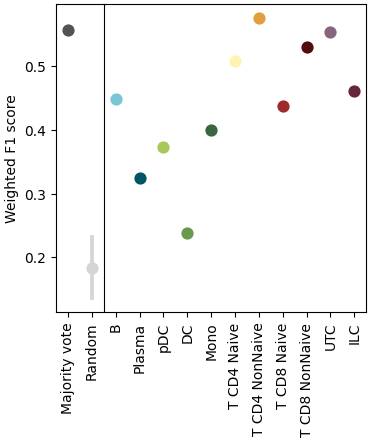

In [53]:
plt.figure(figsize=(4,4))
g = sns.pointplot(pd.concat([cell_type_WF1.query("sex=='both'"),pd.DataFrame.from_dict({'cell_type':['Random']*RandMetricDF.shape[0],'W_F1':RandMetricDF['EXTERNAL_WF1']})], axis=0), 
            x = 'cell_type', 
            hue = 'cell_type', 
                  estimator='mean',
                  errorbar="sd",
            y = 'W_F1', 
            palette  = annotation_Level1_palette | {'Majority vote':'#535353', 'Random':'#D5D5D5'},
               order=['Majority vote','Random'] + cell_type_order)

g.axvline(x=1.5, ymin=0, ymax=1, c="black", ls='-', linewidth=0.8, zorder=0, clip_on=False)


g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

plt.ylabel('Weighted F1 score')
plt.xlabel('')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, fancybox=True)
plt.xticks(rotation=90)

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/referencebalanced_WF1_CTxDisease.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)
plt.show()

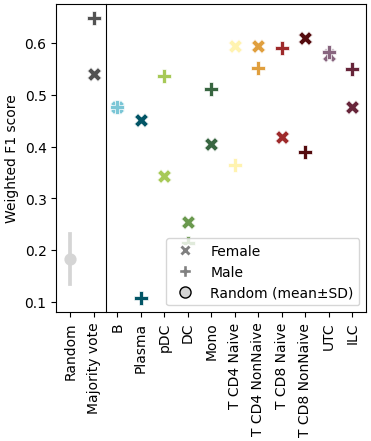

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(4,4))

# Prepare the data
filtered_data = cell_type_WF1.query("sex!='both'")
random_data = pd.DataFrame.from_dict({
    'cell_type': ['Random'] * RandMetricDF.shape[0],
    'W_F1': RandMetricDF['EXTERNAL_WF1']
})

# Create the combined dataset
combined_data = pd.concat([filtered_data, random_data], axis=0)

# First, create the pointplot for Random (which has distribution)
g = sns.pointplot(data=combined_data.query("cell_type == 'Random'"),
                  x='cell_type', 
                  hue='cell_type', 
                  estimator='mean',
                  errorbar="sd", 
                  markers='o', 
                  y='W_F1', 
                  palette={'Random': '#D5D5D5'},
                  order=['Random'])

# Now add scatter points for the other cell types (male/female with different shapes)
cell_types = ['Majority vote'] + cell_type_order
x_positions = list(range(1, len(cell_types) + 1))  # Start from position 1 (Random is at 0)

for i, cell_type in enumerate(cell_types):
    x_pos = x_positions[i]
    
    # Get color from palette
    if cell_type in annotation_Level1_palette:
        color = annotation_Level1_palette[cell_type]
    elif cell_type == 'Majority vote':
        color = '#535353'
    else:
        color = '#535353'
    
    # Plot female points (circles)
    female_data = filtered_data[(filtered_data['cell_type'] == cell_type) & 
                               (filtered_data['sex'] == 'female')]['W_F1']
    if len(female_data) > 0:
        plt.scatter([x_pos] * len(female_data), female_data, 
                   color=color, marker='X', s=100, 
                   edgecolor='white', linewidth=0.5,
                   label='Female' if i == 0 else "", zorder=5)
    
    # Plot male points (triangles)
    male_data = filtered_data[(filtered_data['cell_type'] == cell_type) & 
                             (filtered_data['sex'] == 'male')]['W_F1']
    if len(male_data) > 0:
        plt.scatter([x_pos] * len(male_data), male_data, 
                   color=color, marker='P', s=100,
                   edgecolor='white', linewidth=0.5,
                   label='Male' if i == 0 else "", zorder=5)

# Add the vertical line
g.axvline(x=1.5, ymin=0, ymax=1, c="black", ls='-', linewidth=0.8, zorder=0, clip_on=False)

# Set x-axis labels
all_labels = ['Random'] + [ct.replace('_', ' ') for ct in cell_types]
plt.xticks(range(len(all_labels)), all_labels, rotation=90)

plt.ylabel('Weighted F1 score')
plt.xlabel('')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', 
           markeredgecolor='white', markeredgewidth=1, markersize=8, label='Female'),
    Line2D([0], [0], marker='P', color='w', markerfacecolor='gray', 
           markeredgecolor='white', markeredgewidth=1, markersize=8, label='Male'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#D5D5D5', 
           markeredgecolor='black', markeredgewidth=1, markersize=8, label='Random (mean±SD)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/referencebalanced_WF1_CTxDisease_SEX.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

plt.show()

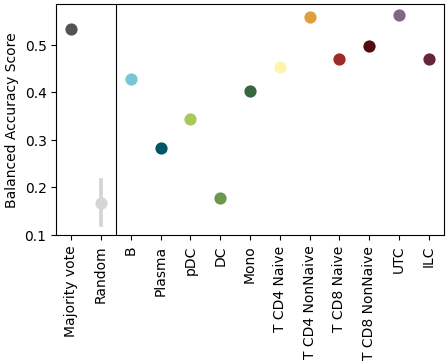

In [58]:
plt.figure(figsize=(5,3))
g = sns.pointplot(pd.concat([cell_type_bas.query("sex=='both'"),pd.DataFrame.from_dict({'cell_type':['Random']*RandMetricDF.shape[0],'BAS':RandMetricDF['EXTERNAL_BAS']})], axis=0), 
            x = 'cell_type', 
            hue = 'cell_type', 
                  estimator='mean',
                  errorbar="sd",
            y = 'BAS', 
            palette  = annotation_Level1_palette | {'Majority vote':'#535353', 'Random':'#D5D5D5'},
               order=['Majority vote','Random'] + cell_type_order)

g.axvline(x=1.5, ymin=0, ymax=1, c="black", ls='-', linewidth=0.8, zorder=0, clip_on=False)


g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

plt.ylabel('Balanced Accuracy Score')
plt.xlabel('')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, fancybox=True)
plt.xticks(rotation=90)

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/referencebalanced_BAS_CTxDisease.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)
plt.show()

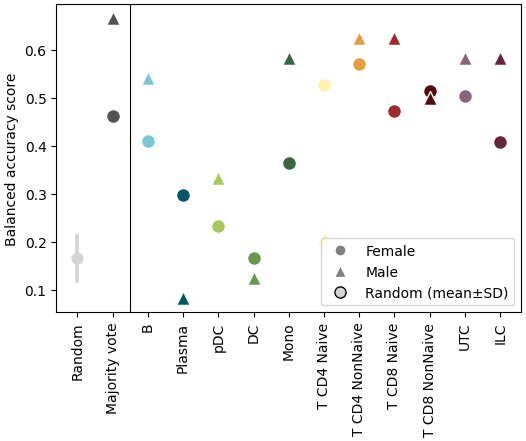

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(6,4))

# Prepare the data
filtered_data = cell_type_bas.query("sex!='both'")
random_data = pd.DataFrame.from_dict({
    'cell_type': ['Random'] * RandMetricDF.shape[0],
    'BAS': RandMetricDF['EXTERNAL_BAS']
})

# Create the combined dataset
combined_data = pd.concat([filtered_data, random_data], axis=0)

# First, create the pointplot for Random (which has distribution)
g = sns.pointplot(data=combined_data.query("cell_type == 'Random'"),
                  x='cell_type', 
                  hue='cell_type', 
                  estimator='mean',
                  errorbar="sd",
                  y='BAS', 
                  palette={'Random': '#D5D5D5'},
                  order=['Random'])

# Now add scatter points for the other cell types (male/female with different shapes)
cell_types = ['Majority vote'] + cell_type_order
x_positions = list(range(1, len(cell_types) + 1))  # Start from position 1 (Random is at 0)

for i, cell_type in enumerate(cell_types):
    x_pos = x_positions[i]
    
    # Get color from palette
    if cell_type in annotation_Level1_palette:
        color = annotation_Level1_palette[cell_type]
    elif cell_type == 'Majority vote':
        color = '#535353'
    else:
        color = '#535353'
    
    # Plot female points (circles)
    female_data = filtered_data[(filtered_data['cell_type'] == cell_type) & 
                               (filtered_data['sex'] == 'female')]['BAS']
    if len(female_data) > 0:
        plt.scatter([x_pos] * len(female_data), female_data, 
                   color=color, marker='o', s=100, 
                   edgecolor='white', linewidth=1,
                   label='Female' if i == 0 else "", zorder=5)
    
    # Plot male points (triangles)
    male_data = filtered_data[(filtered_data['cell_type'] == cell_type) & 
                             (filtered_data['sex'] == 'male')]['BAS']
    if len(male_data) > 0:
        plt.scatter([x_pos] * len(male_data), male_data, 
                   color=color, marker='^', s=100,
                   edgecolor='white', linewidth=1,
                   label='Male' if i == 0 else "", zorder=5)

# Add the vertical line
g.axvline(x=1.5, ymin=0, ymax=1, c="black", ls='-', linewidth=0.8, zorder=0, clip_on=False)

# Set x-axis labels
all_labels = ['Random'] + [ct.replace('_', ' ') for ct in cell_types]
plt.xticks(range(len(all_labels)), all_labels, rotation=90)

plt.ylabel('Balanced accuracy score')
plt.xlabel('')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markeredgecolor='white', markeredgewidth=1, markersize=8, label='Female'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', 
           markeredgecolor='white', markeredgewidth=1, markersize=8, label='Male'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#D5D5D5', 
           markeredgecolor='black', markeredgewidth=1, markersize=8, label='Random (mean±SD)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

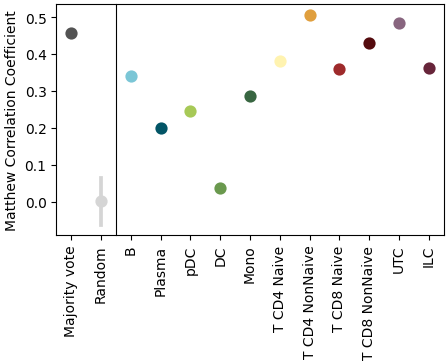

In [60]:
plt.figure(figsize=(5,3))
g = sns.pointplot(pd.concat([cell_type_mcc.query("sex=='both'"),pd.DataFrame.from_dict({'cell_type':['Random']*RandMetricDF.shape[0],'MCC':RandMetricDF['EXTERNAL_MCC']})], axis=0), 
            x = 'cell_type', 
            hue = 'cell_type', 
                  estimator='mean',
                  errorbar="sd",
            y = 'MCC', 
            palette  = annotation_Level1_palette | {'Majority vote':'#535353', 'Random':'#D5D5D5'},
               order=['Majority vote','Random'] + cell_type_order)

g.axvline(x=1.5, ymin=0, ymax=1, c="black", ls='-', linewidth=0.8, zorder=0, clip_on=False)


g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])

plt.ylabel('Matthew Correlation Coefficient')
plt.xlabel('')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, fancybox=True)
plt.xticks(rotation=90)

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/referencebalanced_MCC_CTxDisease.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)
plt.show()

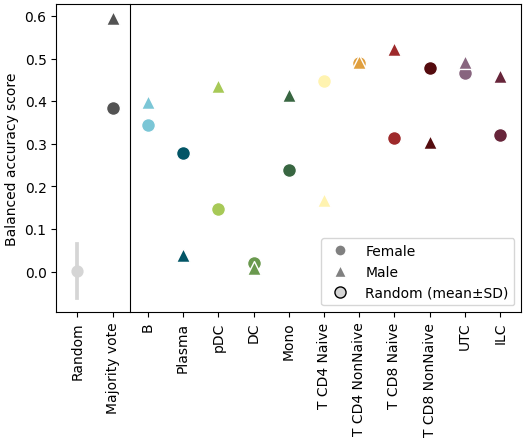

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(6,4))

# Prepare the data
filtered_data = cell_type_mcc.query("sex!='both'")
random_data = pd.DataFrame.from_dict({
    'cell_type': ['Random'] * RandMetricDF.shape[0],
    'MCC': RandMetricDF['EXTERNAL_MCC']
})

# Create the combined dataset
combined_data = pd.concat([filtered_data, random_data], axis=0)

# First, create the pointplot for Random (which has distribution)
g = sns.pointplot(data=combined_data.query("cell_type == 'Random'"),
                  x='cell_type', 
                  hue='cell_type', 
                  estimator='mean',
                  errorbar="sd",
                  y='MCC', 
                  palette={'Random': '#D5D5D5'},
                  order=['Random'])

# Now add scatter points for the other cell types (male/female with different shapes)
cell_types = ['Majority vote'] + cell_type_order
x_positions = list(range(1, len(cell_types) + 1))  # Start from position 1 (Random is at 0)

for i, cell_type in enumerate(cell_types):
    x_pos = x_positions[i]
    
    # Get color from palette
    if cell_type in annotation_Level1_palette:
        color = annotation_Level1_palette[cell_type]
    elif cell_type == 'Majority vote':
        color = '#535353'
    else:
        color = '#535353'
    
    # Plot female points (circles)
    female_data = filtered_data[(filtered_data['cell_type'] == cell_type) & 
                               (filtered_data['sex'] == 'female')]['MCC']
    if len(female_data) > 0:
        plt.scatter([x_pos] * len(female_data), female_data, 
                   color=color, marker='o', s=100, 
                   edgecolor='white', linewidth=1,
                   label='Female' if i == 0 else "", zorder=5)
    
    # Plot male points (triangles)
    male_data = filtered_data[(filtered_data['cell_type'] == cell_type) & 
                             (filtered_data['sex'] == 'male')]['MCC']
    if len(male_data) > 0:
        plt.scatter([x_pos] * len(male_data), male_data, 
                   color=color, marker='^', s=100,
                   edgecolor='white', linewidth=1,
                   label='Male' if i == 0 else "", zorder=5)

# Add the vertical line
g.axvline(x=1.5, ymin=0, ymax=1, c="black", ls='-', linewidth=0.8, zorder=0, clip_on=False)

# Set x-axis labels
all_labels = ['Random'] + [ct.replace('_', ' ') for ct in cell_types]
plt.xticks(range(len(all_labels)), all_labels, rotation=90)

plt.ylabel('Balanced accuracy score')
plt.xlabel('')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markeredgecolor='white', markeredgewidth=1, markersize=8, label='Female'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', 
           markeredgecolor='white', markeredgewidth=1, markersize=8, label='Male'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#D5D5D5', 
           markeredgecolor='black', markeredgewidth=1, markersize=8, label='Random (mean±SD)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

**Score for each cell-type and disease**


In [56]:
import string

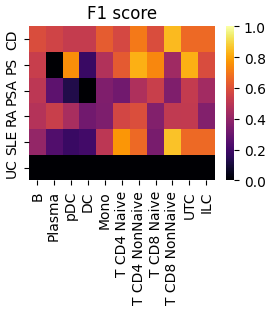

In [ ]:
data = cell_type_F1.query("cell_type != 'Majority vote'").pivot(columns='disease_true', index = 'cell_type', values = 'F1').T.fillna(0)
if embedded_space !='sample':

    plt.figure(figsize=(3,2))
    
    g = sns.heatmap(data.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data.index.tolist())],
                    cell_type_order],square=False,vmin=0,vmax=1,cmap='inferno')

    g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])
    g.set_yticks(g.get_yticks(), [[l[0].upper() + l[1:] for l in t.get_text().split()][0] for t in g.get_yticklabels()])

    g.set_title('F1 score')
    g.set_xlabel("")
    g.set_ylabel("")
    
    plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/clusterMap_F1_CTxDisease_noMV.pdf"),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
    )

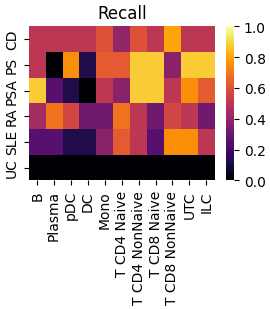

In [ ]:
data = cell_type_recall.query("cell_type != 'Majority vote'").pivot(columns='disease_true', index = 'cell_type', values = 'recall').T.fillna(0)
if embedded_space !='sample':

    plt.figure(figsize=(3,2))
    
    g = sns.heatmap(data.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data.index.tolist())],
                    cell_type_order],square=False,vmin=0,vmax=1,cmap='inferno')

    g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])
    g.set_yticks(g.get_yticks(), [[l[0].upper() + l[1:] for l in t.get_text().split()][0] for t in g.get_yticklabels()])

    g.set_title('Recall')
    g.set_xlabel("")
    g.set_ylabel("")
    
    plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/clusterMap_RECALL_CTxDisease_noMV.pdf"),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
    )

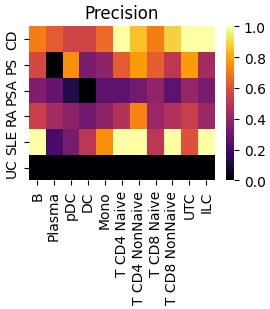

In [ ]:
data = cell_type_precision.query("cell_type != 'Majority vote'").pivot(columns='disease_true', index = 'cell_type', values = 'precision').T.fillna(0)
if embedded_space !='sample':

    plt.figure(figsize=(3,2))
    
    g = sns.heatmap(data.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data.index.tolist())],
                    cell_type_order],square=False,vmin=0,vmax=1,cmap='inferno')

    g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])
    g.set_yticks(g.get_yticks(), [[l[0].upper() + l[1:] for l in t.get_text().split()][0] for t in g.get_yticklabels()])

    g.set_title('Precision')
    g.set_xlabel("")
    g.set_ylabel("")
    
    plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/clusterMap_PRECISION_CTxDisease_noMV.pdf"),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
    )

### Table with F1, precision, recall, and accuracy score per class

In [47]:
# def getClassMetricsDF(data=None, disease_list = None, y_true_cn = 'disease', y_pred_cn = 'disease_pred', cell_type_cn = 'Level1', include_aggregated = True):

#     import pandas as pd
#     from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

#     classMtx = dict()
#     for f in [recall_score, precision_score, f1_score, accuracy_score]:
#         classMtx[f.__name__] = dict()
#         for ct in data[cell_type_cn].unique():
#             if f.__name__ == 'accuracy_score':
#                 disease_res = []
#                 for d in disease_list:
#                     disease_res.append(
#                         f(y_true = data.query(f"{cell_type_cn} == @ct")[y_true_cn] == d, 
#                           y_pred = data.query(f"{cell_type_cn} == @ct")[y_pred_cn] == d
#                          )                        
#                     )
                    
#                 classMtx[f.__name__][ct] = disease_res
#             else:
#                 classMtx[f.__name__][ct] = f(y_true = data.query(f"{cell_type_cn} == @ct")[y_true_cn],
#                                              y_pred = data.query(f"{cell_type_cn} == @ct")[y_pred_cn], 
#                                              labels = disease_list, 
#                                              average = None)

#         if include_aggregated:
#             # computing the metric on the overall result, not stratified by cell-types
#             if f.__name__ == 'accuracy_score':
#                 disease_res = []
#                 for d in disease_list:
#                     disease_res.append(
#                         f(y_true = data[y_true_cn] == d, 
#                           y_pred = data[y_pred_cn] == d)                        
#                     )
#                 classMtx[f.__name__]['aggregated'] = disease_res
#             else:
#                 classMtx[f.__name__]['aggregated'] = f(y_true = data[y_true_cn], 
#                                                        y_pred = data[y_pred_cn], 
#                                                        labels = disease_list, average = None)

#         df = pd.concat([pd.DataFrame.from_dict(classMtx[f]).T.assign(metric=f) for f in classMtx]).reset_index()
#         df.columns = ['stratification'] + disease_list + ['metric']
        
#     return df.loc[:,['metric', 'stratification'] + disease_list]

In [48]:
MetricsDF = getClassMetricsDF(data = labelsMelt.fillna('na'), 
                              y_true_cn='disease_true', y_pred_cn='disease_pred', cell_type_cn='cell_type', 
                              disease_list=[d for d in diseases_palette.keys() if (d in labelsMelt.disease_true.unique())], 
                              include_aggregated=False)

In [53]:
with pd.ExcelWriter(here('03_downstream_analysis/metricXdisease.xlsx'), mode = 'a', if_sheet_exists = 'replace') as writer:  
    MetricsDF.to_excel(writer, sheet_name='patientClassifier_centralizedApproach', index_label=None, index=False)

### Confusion Matrix

#### Functions

In [61]:
# Computing the confusion matrix
def getConfusionMatrix(predTestDF = None, predCol = 'y_pred', gtCol = 'y_test', normalize='columns'):

    # normalize could be False, 'rows', or 'columns' (default).
    
    import pandas as pd

    if normalize == False:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], dropna=False)
    else:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], normalize=normalize, dropna=False)

    if confusionMatrix.shape[0] < confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.columns.tolist(), confusionMatrix.index.tolist()):
            confusionMatrix.loc[d,:] = 0
    elif confusionMatrix.shape[0] > confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.index.tolist(),confusionMatrix.columns.tolist()):
            confusionMatrix[d] = 0   

    return(confusionMatrix)

In [62]:
def reorder_ConfMatrix(confusionMatrix=None, elementList = None):

    confusionMatrix = confusionMatrix.reindex(elementList, axis=0).reindex(elementList, axis=1)

    return(confusionMatrix)

In [63]:
def mask_entries(confusionMatrix=None, lowerThan = 0, cmap='viridis'):
    confusionMatrix_nan = confusionMatrix.copy()
    confusionMatrix_nan[confusionMatrix_nan <= lowerThan] = np.nan
    return(confusionMatrix_nan)
    

#### Changing the PyComplexHeatmap code

https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/composite_heatmaps.html#Composite-two-heatmaps-horizontally-for-mouse-DNA-methylation-array-dataset

The following change is required to avoid reordering columns and rows. So, disease in the same category are close to each others

In [64]:
def _reorder_rows(self):
    self.row_split_dendrogram = False
    if self.verbose >= 1:
        print("Reordering rows..")
    if self.row_split is None and self.row_cluster:
        self.calculate_row_dendrograms(
            self.data2d
        )  # xind=self.dendrogram_row.reordered_ind
        self.row_order = [
            self.dendrogram_row.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.row_split, int) and self.row_cluster:
        self.calculate_row_dendrograms(self.data2d)
        self.row_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_row.linkage,
                    t=self.row_split,
                    criterion="maxclust",
                ),
                index=self.data2d.index.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_row.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.row_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.row_split, pd.Series):
            self.row_split = self.row_split.to_frame(name=self.row_split.name)
        cols = self.row_split.columns.tolist()
        row_clusters = self.row_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.row_split_order is None:
            self.row_split_order = row_clusters.index.tolist()
        elif self.row_split_order == 'cluster_between_groups':
            mat=pd.concat([
                self.data2d.loc[rows].mean() for rows in row_clusters.tolist()],
                          axis=1).T #columns are original columns
            mat.index=row_clusters.index.tolist()
            sizes=row_clusters.apply(lambda x:len(x)).tolist()
            self.calculate_row_dendrograms(mat,sizes=sizes)
            self.row_split_order = self.dendrogram_row.dendrogram["ivl"]
            self.row_split_dendrogram=self.dendrogram_row
        self.row_clusters = row_clusters.loc[self.row_split_order].to_dict()
    elif not self.row_cluster:
        self.row_order = [self.data2d.index.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.row_order = []
    self.dendrogram_rows = []
    for i, cluster in enumerate(self.row_clusters):
        rows = self.row_clusters[cluster]
        if len(rows) <= 1:
            self.row_order.append(rows)
            self.dendrogram_rows.append(None)
            continue
        if self.row_cluster: #cluster within groups
            self.calculate_row_dendrograms(self.data2d.loc[rows])
            self.dendrogram_rows.append(self.dendrogram_row)
            self.row_order.append(self.dendrogram_row.dendrogram["ivl"])
        else:
            self.row_order.append(rows)

def _reorder_cols(self):
    self.col_split_dendrogram=False
    if self.verbose >= 1:
        print("Reordering cols..")
    if self.col_split is None and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_order = [
            self.dendrogram_col.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.col_split, int) and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_col.linkage,
                    t=self.col_split,
                    criterion="maxclust",
                ),
                index=self.data2d.columns.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_col.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.col_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.col_split, pd.Series):
            self.col_split = self.col_split.to_frame(name=self.col_split.name)
        cols = self.col_split.columns.tolist()
        col_clusters = self.col_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.col_split_order is None:
            self.col_split_order = col_clusters.index.tolist()
        elif self.col_split_order == 'cluster_between_groups':
            mat = pd.concat([
                self.data2d.loc[:,cols].mean(axis=1) for cols in col_clusters.tolist()],
                axis=1)  # index are original rows labels
            mat.columns = col_clusters.index.tolist()
            sizes = col_clusters.apply(lambda x: len(x)).tolist()
            self.calculate_col_dendrograms(mat, sizes=sizes)
            self.col_split_order = self.dendrogram_col.dendrogram["ivl"]
            self.col_split_dendrogram = self.dendrogram_col
        self.col_clusters = col_clusters.loc[self.col_split_order].to_dict()
    elif not self.col_cluster:
        self.col_order = [self.data2d.columns.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.col_order = []
    self.dendrogram_cols = []
    for i, cluster in enumerate(self.col_clusters):
        cols = self.col_clusters[cluster]
        if len(cols) <= 1:
            self.col_order.append(cols)
            self.dendrogram_cols.append(None)
            continue
        if self.col_cluster:
            self.calculate_col_dendrograms(self.data2d.loc[:, cols])
            self.dendrogram_cols.append(self.dendrogram_col)
            self.col_order.append(self.dendrogram_col.dendrogram["ivl"])
        else:
            self.col_order.append(cols)

def plot_matrix(self, row_order, col_order):
    col_order=row_order.copy()
    if self.verbose >= 1:
        print("Plotting matrix..")
    nrows = len(row_order)
    ncols = len(col_order)
    self.wspace = (
        self.col_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().width / ncols)
    )  # 1mm=mm2inch inch
    self.hspace = (
        self.row_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().height / nrows)
    )  # height
    self.heatmap_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
        nrows,
        ncols,
        hspace=self.hspace,
        wspace=self.wspace,
        subplot_spec=self.gs[1, 1],
        height_ratios=[len(rows) for rows in row_order],
        width_ratios=[len(cols) for cols in col_order],
    )

    annot = self.kwargs.pop("annot", None)
    if annot is None or annot is False:
        pass
    else:
        if isinstance(annot, bool):
            annot_data = self.data2d
        else:
            annot_data = annot.copy()
            if annot_data.shape != self.data2d.shape:
                err = "`data` and `annot` must have same shape."
                raise ValueError(err)

    self.heatmap_axes = np.empty(shape=(nrows, ncols), dtype=object)
    # if nrows > 1 or ncols > 1:
    self.ax_heatmap.set_axis_off()
    for i, rows in enumerate(row_order):
        for j, cols in enumerate(col_order):
            # print(i,j)
            ax1 = self.ax_heatmap.figure.add_subplot(
                self.heatmap_gs[i, j],
                sharex=self.heatmap_axes[0, j],
                sharey=self.heatmap_axes[i, 0],
            )
            ax1.set_xlim([0, len(rows)])
            ax1.set_ylim([0, len(cols)])
            annot1 = None if annot is None else annot_data.loc[rows, cols]
            # heatmap(self.data2d.loc[rows, cols], ax=ax1, cbar=False, cmap=self.cmap,
            #         cbar_kws=None, mask=self.mask.loc[rows, cols], rasterized=self.rasterized,
            #         xticklabels='auto', yticklabels='auto', annot=annot1, **self.kwargs)
            plot_heatmap(
                self.data2d.loc[rows, cols],
                ax=ax1,
                cmap=self.cmap,
                mask=self.mask.loc[rows, cols],
                rasterized=self.rasterized,
                xticklabels="auto",
                yticklabels="auto",
                annot=True,
                **self.kwargs
            )
            self.heatmap_axes[i, j] = ax1
            ax1.yaxis.label.set_visible(False)
            ax1.xaxis.label.set_visible(False)
            ax1.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelright=False,
                top=False,
                bottom=False,
                labeltop=False,
                labelbottom=False,
            )


In [65]:
ClusterMapPlotter._reorder_rows = _reorder_rows
ClusterMapPlotter._reorder_cols = _reorder_cols
# ClusterMapPlotter.plot_matrix = plot_matrix

In [66]:
MajorityVote_confusionMatrix = getConfusionMatrix(predTestDF= labelsMelt.query("cell_type == 'Majority vote'"), predCol = 'disease_pred', gtCol = 'disease_true', normalize='columns')
MajorityVote_confusionMatrix_ord = reorder_ConfMatrix(mask_entries(MajorityVote_confusionMatrix, lowerThan = -1), elementList=disease_cat_ordDF.elementList)

In [67]:
MajorityVote_confusionMatrix_ord[MajorityVote_confusionMatrix_ord == 0.0] = np.nan
MajorityVote_confusionMatrix_ord = MajorityVote_confusionMatrix_ord.dropna(how='all').dropna(how='all', axis=1).fillna(0)

In [68]:
# rows
rowConditions = MajorityVote_confusionMatrix_ord.index.tolist()
rowAnnDF = pd.DataFrame.from_dict({'disease_cat' : [diseaseCategories[c] for c in rowConditions], 'disease':rowConditions}).set_index('disease')
row_ann = HeatmapAnnotation(disease_group=anno_simple(rowAnnDF.disease_cat, colors=diseasesGroup_palette, rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=0,verbose=0, label_kws={'text':None}, plot=False, legend=False)

# columns
colConditions = MajorityVote_confusionMatrix_ord.columns.tolist()
colAnnDF = pd.DataFrame.from_dict({'disease_cat' : [diseaseCategories[c] for c in colConditions], 'disease':colConditions}).set_index('disease')
col_ann = HeatmapAnnotation(disease_group=anno_simple(colAnnDF.disease_cat, colors=diseasesGroup_palette, rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=1,verbose=0, label_kws={'text':None}, plot=False, legend=False)

Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


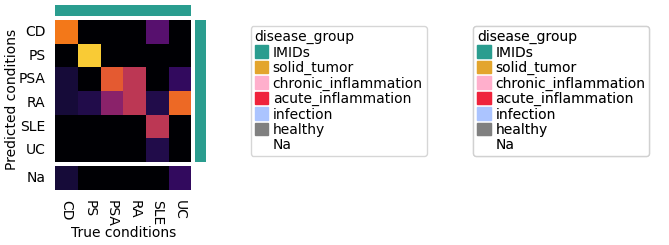

In [ ]:

plt.figure(figsize=(2, MajorityVote_confusionMatrix_ord.shape[0] * .35))
cm = ClusterMapPlotter(data=MajorityVote_confusionMatrix_ord.fillna(0), 
                       right_annotation=row_ann, 
                       top_annotation=col_ann, 
                       row_split=rowAnnDF.disease_cat, #row_split_order=diseaseCatOrd,
                       col_split=colAnnDF.disease_cat, #col_split_order=diseaseCatOrd,
                       show_rownames=True,show_colnames=True, xlabel = 'True conditions', ylabel = 'Predicted conditions',
                       plot=True, fmt=None,
                       row_cluster=False, col_cluster=False, standard_scale = None,
                       row_dendrogram=False,col_dendrogram=False, verbose=False,
                       cmap='inferno', rasterized=False, 
                       row_split_gap=1, col_split_gap=1, legend=False, label = 'Proportion\n(col norm)', legend_vpad=5,
                       vmax = 1, vmin = 0)

plt.savefig(here(f"03_downstream_analysis/09_patient_classifier/SCGT00_CentralizedDataset/{M_dir}/MajorityVote_confusionMatrix.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)
